## Generative Adversarial Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
# 시간을 측정
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf                     
from IPython.display import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, InputLayer, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

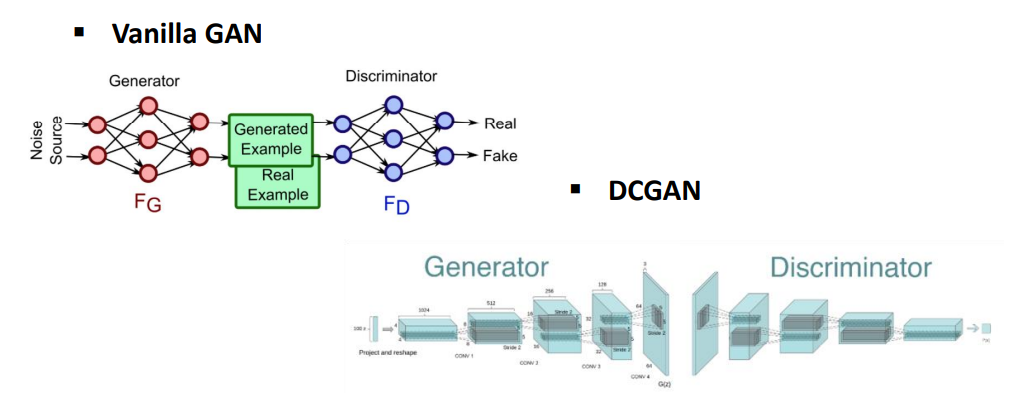

In [3]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/DCGAN.png')

##### 1) 이미지 불러오고 시각화 & 처리 : MNIST 데이터 

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
def show_images(images, labels, ncols=6):
    # 이미지를 한번에 여러개 보여주고 싶다. 여기서는 1x6로 총 6개
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    # 이미지를 보여줄 규격과 1x8에서 각 해당하는 위치를 잡는 것이다. 22x6은 규격, nrows는 행, ncols은 열을 말한다.
    for i in range(ncols):
        # 열만 존재하기에 열 갯수만큼 반복하면서
        axs[i].imshow(images[i], cmap='gray')
        # 각각에 해당하는 위치에 이미지를 시각화한다.
        axs[i].set_title(labels[i])
        # 이미지에 해당하는 class_name도 함께 시각화 한다.

In [6]:
print('train dataset shape:', train_images.shape, train_labels.shape)
print('test dataset shape:', test_images.shape, test_labels.shape)

train dataset shape: (60000, 28, 28) (60000,)
test dataset shape: (10000, 28, 28) (10000,)


* 6개씩 시각화

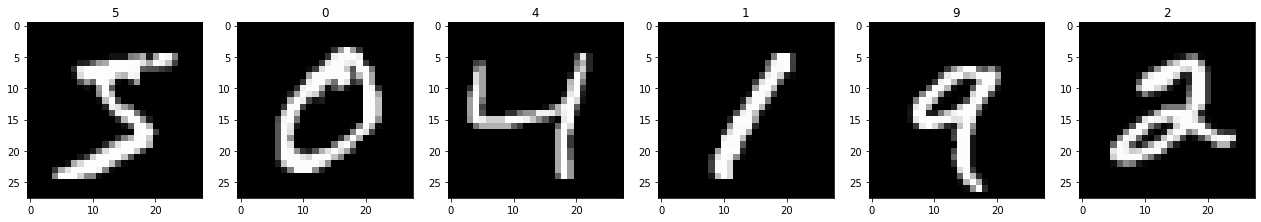

In [7]:
show_images(train_images[:6], train_labels[:6], ncols=6)

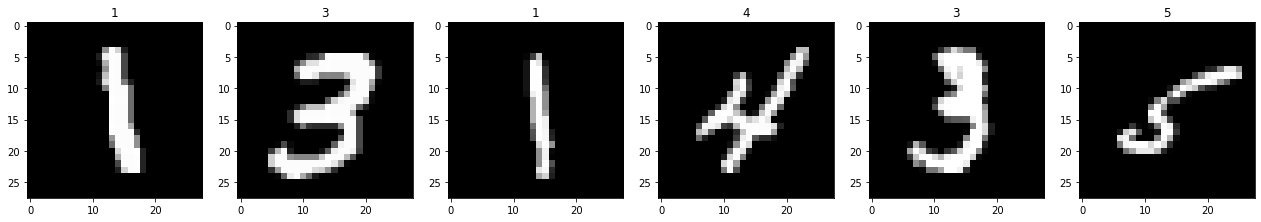

In [8]:
show_images(train_images[6:12], train_labels[6:12], ncols=6)

* 이미지 정규화

In [9]:
# Normalize the images to [-1, 1] (* tanh로 출력)
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

In [10]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [11]:
# 데이터가 [-1, 1] 사이로 정규화 되었는지 확인
print(np.amin(train_images), np.amax(train_images))

-1.0 1.0


In [12]:
print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)

(60000, 28, 28)
(10000, 28, 28)
(28, 28)


In [13]:
BUFFER_SIZE = 60000
# 전체 이미지 사이즈
BATCH_SIZE = 256
# 배치 사이즈

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# 배치 사이즈 만큼 전체 데이터를 섞어서 할당

##### 2) Model

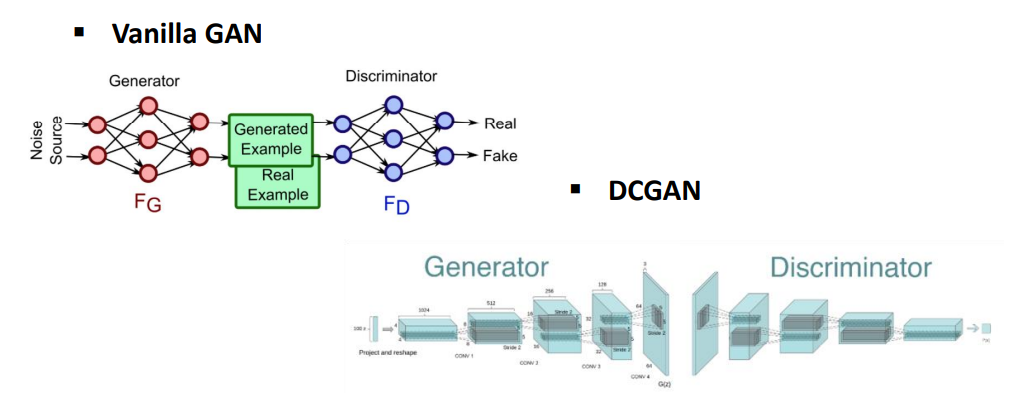

In [14]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/DCGAN.png')

* Generator

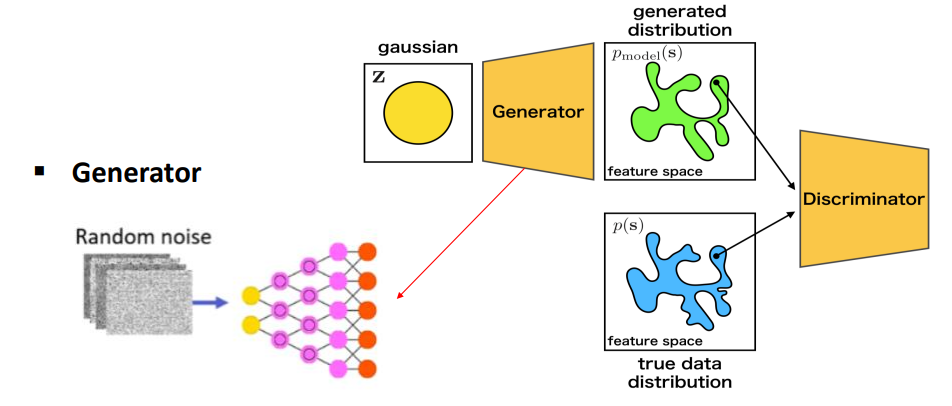

In [15]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/gen.png')

1) Generator : Random noise를 input으로 이미지 크기의 형태를 출력한다.<br>
  → Discriminator의 Feedback을 통해 진짜 이미지처럼 보이도록 훈련한다.<br>
2) Discriminator : Generator에서 나온 출력 값과 실제 이미지를 Input으로 입력받아서 진짜 이미지이면 1, 아니면 0으로 구분하도록 훈련한다.

* VanillaGAN
<br> Model을 Dense Layer로 구성하면 된다.

* Deep Convolutinal GAN<br>
Model을 Convolution Layer로 구성한다.

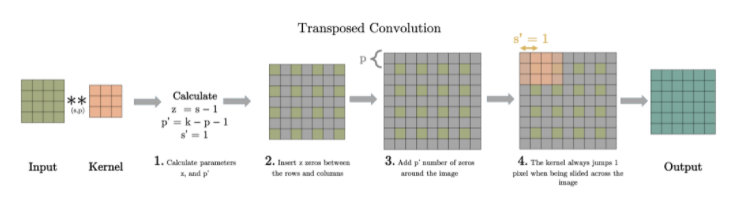

In [16]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/tconv.png')

In [17]:
G = Sequential([
    InputLayer(input_shape=(100,)), 
    # 100크기의 Random Noise를 입력
    Dense(7*7*256, use_bias=False), 
    # 이미지 형태로 변환하기 위해서 먼저 Dense Layer 구성
    BatchNormalization(),
    LeakyReLU(),
    Reshape(target_shape=(7, 7, 256)),               
    # 7x7 크기의 channel 256 영상으로 크기 변환
    Conv2DTranspose(128, (3,3), strides=(1,1), padding='same', use_bias=False), 
    # 7x7 크기의 128 channel 영상
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', use_bias=False), 
    # 14x14 크기의 64 channel 영상 
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(1, (3,3), strides=(2,2), padding='same', use_bias=False, activation='tanh'), 
    # 28x28 크기의 1 channel 영상 
    Reshape(target_shape=(28, 28)),                                             
    # 28x28 크기 gray 영상으로 크기 변환
])

In [18]:
G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        294912    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

* Discriminator

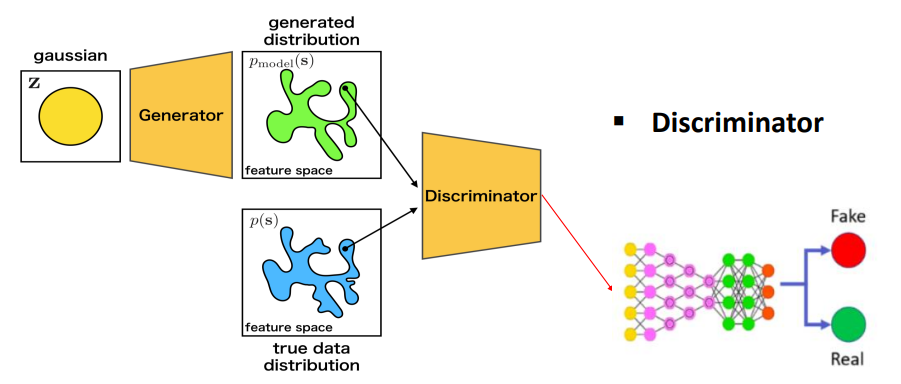

In [19]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/dis.png')

1) Discriminator : Generator가 생성한 가짜 이미지와 진짜 이미지를 구분하도록 훈련한다.<br>
2) Generator : 앞서 구현된 Generator는 1)에서 받은 FeedBack을 갖고 다시 학습하여 최대한 진짜 이미지처럼 보이게 훈련한다.

In [20]:
# Discriminator 모델 작성 : 앞서 계속 사용했던 Image classification Model과 동일.

D = Sequential([
    InputLayer(input_shape=(28,28)),
    Reshape(target_shape=(28, 28, 1)),
    Conv2D(64, (5,5), strides=(2,2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5,5), strides=(2,2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(), # 7*7*128
    Dense(1), # True, False
])

In [21]:
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)        

* Generator Test

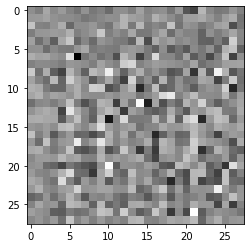

In [22]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = tf.random.normal([1,100])
# 랜덤한 노이즈
fake_image_test = G(test_noise, training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')
plt.show()

→ 그냥 노이즈

## GAN 목적함수
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

* log 0 = -**∞**
* log 1 = 0

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# from_logits : normalize가 되어있으면 False 그렇지 않으면 True 즉, softmax의 출력이면 False, 아니면 True
# tf에서는 후자를 선호

### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$
<br> G를 고정시키고 수식을 정리해보면 BCE Loss가 나온다.

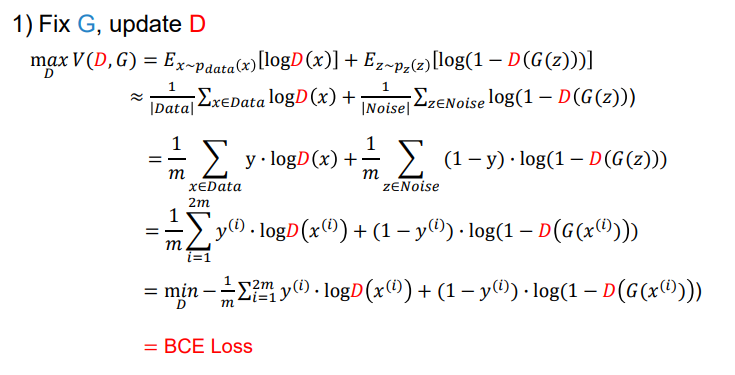

In [24]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/dis_loss.png')

→ 위의 수식을 천천히 따라가보면, 결국 BCE Loss를 최소화 시키는 방향으로 Discriminator를 학습하면 된다. 

In [25]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
# real_output을 1로 학습한다.
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
# fake_output을 0으로 학습한다.
  total_loss = real_loss + fake_loss
  return total_loss

### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$
<br> D를 고정시키고 수식을 정리해보면 real image label과의 BCE Loss가 나온다.

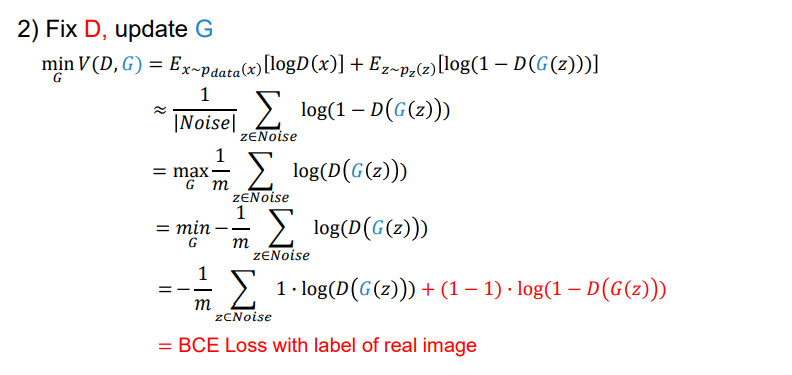

In [26]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/03/gen_lss.png')

→ 위의 수식을 따라가면 결국 가짜 이미지를 입력으로 주고 label로 진짜(=1)가 되도록 BCE Loss를 최소화 시키면 된다.

In [27]:
# Generator loss 정의

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    # 가짜 이미지를 입력하고 진짜 label을 주어 학습하게 한다.

In [28]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4) # 10의 -4승
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
# 학습 루프 설정

EPOCHS = 40
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

* 학습 루프 정의

In [30]:
@tf.function
# 가속화 tf1이해

def train_step(real_images):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
    # batch 학습을 하기에 batch 크기의 noise 생성
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        # 훈련 루프의 세부사항을 수정 제어.
        # with안에서의 연산은 모두 기록되며 grad를 계산할 수 있게 된다.
        fake_images = G(noises, training=True)
        # 가짜 이미지 생성
        real_output = D(real_images, training=True)
        # 진짜 이미지 통과
        fake_output = D(fake_images, training=True)
        # 가짜 이미지 통과
    
        gen_loss = G_loss(fake_output)
        # 가짜 이미지를 진짜로 구분하게 학습
        
        dsc_loss = D_loss(real_output, fake_output)
        # 진짜 이미지 진짜로 구분하게 학습
        # 가짜 이미지 가짜로 구분하게 학습
    
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  # GD 값 계산
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  # GD 값 계산
    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  # 최적화
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables)) 
  # 최적화

* 테스트 루프 정의

In [31]:
def test_step(real_images):
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
    # 랜덤 노이즈 생성
    fake_images = G(noises, training=False)
    # 훈련된 모델에 입력
    real_output = D(real_images, training=False)
    # 실제 이미지를 넣었을때의 출력
    fake_output = D(fake_images, training=False)    
    # 가짜 이미지를 넣었을때의 출력
    gen_loss = G_loss(fake_output)
    # loss 계산
    dsc_loss = D_loss(real_output, fake_output)
    # loss 계산
    plt.imshow(fake_images[0], cmap='gray')
    plt.show()
    # 가짜 이미지 1장 출력
    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

* 훈련하면서 Epoch 마다 출력하도록 함수 정의

In [32]:
# 학습 함수

def train(dataset, epochs):
  # 데이터와 epoch를 입력으로 받는다.
  for epoch in range(epochs):
  # epoch 만큼 반복
    start = time.time()
    
    for i, image_batch in enumerate(dataset):
    # dataset에서 batch만큼 가져오기
      train_step(image_batch)
      # 학습 시작
      if i == 0:
        test_step(image_batch)
        # epoch마다 loss 출력
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

* train

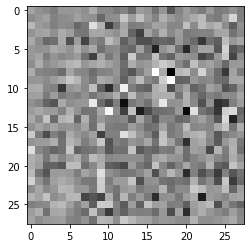

Generator loss: 0.69227636 Discriminator loss: 1.3038912
Time for epoch 1 is 14.199137449264526 sec


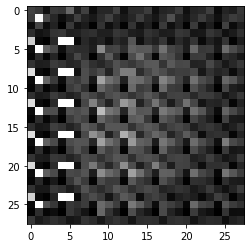

Generator loss: 5.736911 Discriminator loss: 0.020067746
Time for epoch 2 is 10.474977016448975 sec


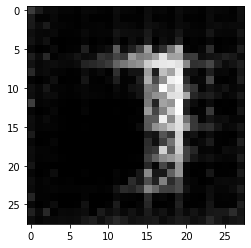

Generator loss: 0.53855604 Discriminator loss: 1.2060645
Time for epoch 3 is 10.557398319244385 sec


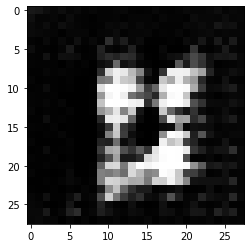

Generator loss: 0.99077237 Discriminator loss: 1.0556779
Time for epoch 4 is 10.688829898834229 sec


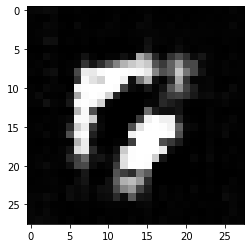

Generator loss: 1.7377961 Discriminator loss: 0.5503181
Time for epoch 5 is 10.793341875076294 sec


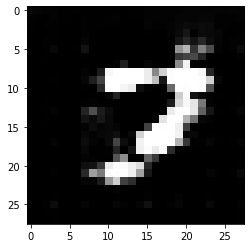

Generator loss: 0.8681883 Discriminator loss: 1.1416092
Time for epoch 6 is 10.922990798950195 sec


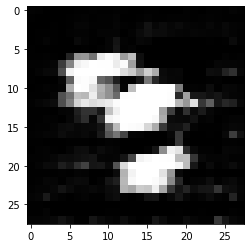

Generator loss: 1.3963987 Discriminator loss: 0.99819523


KeyboardInterrupt: ignored

In [33]:
# 학습!!!
train(train_dataset, EPOCHS)

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
    ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')

plt.show()